<a href="https://colab.research.google.com/github/ArashDehghanyan/ml-and-vision-practices/blob/main/autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Import libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mlp
import tensorflow as tf
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model

In [2]:
print(tf.__version__)
print(np.__version__)
print(pd.__version__)

2.8.0
1.21.6
1.3.5


#Load Dataset

In [3]:
(x_train, _), (x_test, _) = fashion_mnist.load_data()

print(type(x_train))
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

print(x_train.shape)
print(x_test.shape)

4431872/4422102 [==============================] - 0s 0us/step
<class 'numpy.ndarray'>
(60000, 28, 28)
(10000, 28, 28)


#Basic Autoencoder

In [7]:
latent_dim = 64

class Autoencoder(Model):
    def __init__(self, latent_dim):
        super(Autoencoder, self).__init__()
        self.laten_dim = latent_dim
        self.encoder = tf.keras.Sequential([
            layers.Flatten(),
            layers.Dense(latent_dim, activation='relu')
        ])
        self.decoder = tf.keras.Sequential([
            layers.Dense(784, activation='sigmoid'),
            layers.Reshape((28, 28))
        ])

    def call(self, X):
        encoded = self.encoder(X)
        decoded = self.decoder(encoded)
        return decoded

In [8]:
autoencoder = Autoencoder(latent_dim)
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

In [9]:
autoencoder.fit(x_train, x_train,
                epochs=10,
                shuffle=True,
                validation_data=(x_test, x_test))

Epoch 1/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0237 - val_loss: 0.0131
Epoch 2/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0116 - val_loss: 0.0107
Epoch 3/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0101 - val_loss: 0.0097
Epoch 4/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0094 - val_loss: 0.0094
Epoch 5/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0091 - val_loss: 0.0091
Epoch 6/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0090 - val_loss: 0.0090
Epoch 7/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0089 - val_loss: 0.0089
Epoch 8/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0088 - val_loss: 0.0089
Epoch 9/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0087 - val_loss: 0.0088
Epoch 10/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.008

In [10]:
encoded_imgs = autoencoder.encoder(x_test).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

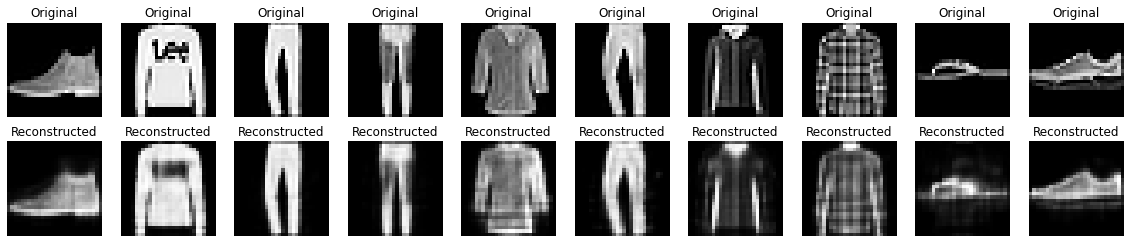

In [11]:
n = 10

plt.figure(figsize=(20, 4))
for i in range(n):
    ax = plt.subplot(2, n, i+1)
    plt.imshow(x_test[i])
    plt.title("Original")
    plt.gray()
    plt.axis('off')

    ax = plt.subplot(2, n, i+1+n)
    plt.imshow(decoded_imgs[i])
    plt.title("Reconstructed")
    plt.gray()
    plt.axis('off')

plt.show()

#Image denoising

In [12]:
(x_train, _), (x_test, _) = fashion_mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

x_train = tf.expand_dims(x_train, -1)
x_test = tf.expand_dims(x_test, -1)

print(x_train.shape)
print(x_test.shape)

(60000, 28, 28, 1)
(10000, 28, 28, 1)


In [13]:
# Adding random noise
noise_factor = 0.2
x_train_noisy = tf.clip_by_value(x_train+noise_factor*tf.random.normal(shape=x_train.shape), clip_value_min=0., clip_value_max=1.)
x_test_noisy = tf.clip_by_value(x_test+noise_factor*tf.random.normal(shape=x_test.shape), clip_value_min=0., clip_value_max=1.)

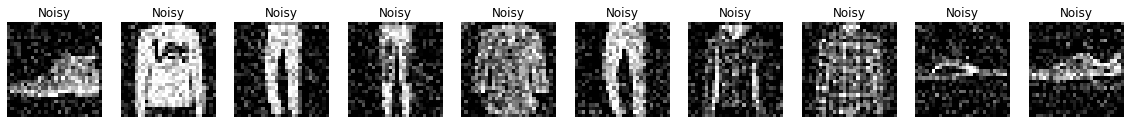

In [18]:
# Plot noisy images
plt.figure(figsize=(20, 4))
for i in range(n):
    plt.subplot(2, n, i+1)
    plt.imshow(tf.squeeze(x_test_noisy[i], -1))
    plt.title('Noisy')
    plt.gray()
    plt.axis('off')
plt.show()

#Define a convolutional Autoencoder

In [21]:
class Denoise(Model):
    def __init__(self):
        super(Denoise, self).__init__()
        self.encoder = tf.keras.Sequential([
            layers.Input(shape=(28, 28, 1)),
            layers.Conv2D(16, (3, 3), activation='relu', padding='same', strides=2),
            layers.Conv2D(8, (3, 3), activation='relu', padding='same', strides=2)
        ])

        self.decoder = tf.keras.Sequential([
            layers.Conv2DTranspose(8, kernel_size=3, padding='same', strides=2, activation='relu'),
            layers.Conv2DTranspose(16, kernel_size=3, strides=2, padding='same', activation='relu'),
            layers.Conv2D(1, kernel_size=3, activation='sigmoid', padding='same')
        ])
    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [22]:
autoencoder = Denoise()
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())
autoencoder.fit(
    x_train_noisy, x_train, epochs=10, shuffle=True, 
    validation_data=(x_test_noisy, x_test)
)

Epoch 1/10
1875/1875 [==============================] - 84s 44ms/step - loss: 0.0171 - val_loss: 0.0104
Epoch 2/10
1875/1875 [==============================] - 79s 42ms/step - loss: 0.0096 - val_loss: 0.0093
Epoch 3/10
1875/1875 [==============================] - 79s 42ms/step - loss: 0.0088 - val_loss: 0.0086
Epoch 4/10
1875/1875 [==============================] - 77s 41ms/step - loss: 0.0084 - val_loss: 0.0083
Epoch 5/10
1875/1875 [==============================] - 77s 41ms/step - loss: 0.0081 - val_loss: 0.0081
Epoch 6/10
1875/1875 [==============================] - 77s 41ms/step - loss: 0.0080 - val_loss: 0.0079
Epoch 7/10
1875/1875 [==============================] - 75s 40ms/step - loss: 0.0078 - val_loss: 0.0078
Epoch 8/10
1875/1875 [==============================] - 76s 40ms/step - loss: 0.0077 - val_loss: 0.0077
Epoch 9/10
1875/1875 [==============================] - 75s 40ms/step - loss: 0.0077 - val_loss: 0.0076
Epoch 10/10
1875/1875 [==============================] - 89s 48m

In [23]:
autoencoder.encoder.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 14, 14, 16)        160       
                                                                 
 conv2d_4 (Conv2D)           (None, 7, 7, 8)           1160      
                                                                 
Total params: 1,320
Trainable params: 1,320
Non-trainable params: 0
_________________________________________________________________


In [24]:
autoencoder.decoder.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_transpose_2 (Conv2DT  (None, 14, 14, 8)        584       
 ranspose)                                                       
                                                                 
 conv2d_transpose_3 (Conv2DT  (None, 28, 28, 16)       1168      
 ranspose)                                                       
                                                                 
 conv2d_5 (Conv2D)           (None, 28, 28, 1)         145       
                                                                 
Total params: 1,897
Trainable params: 1,897
Non-trainable params: 0
_________________________________________________________________


In [25]:
# Plotting both noisy and denoised images
encoded_imgs = autoencoder.encoder(x_test_noisy).numpy()
denoised_imgs = autoencoder.decoder(encoded_imgs).numpy()

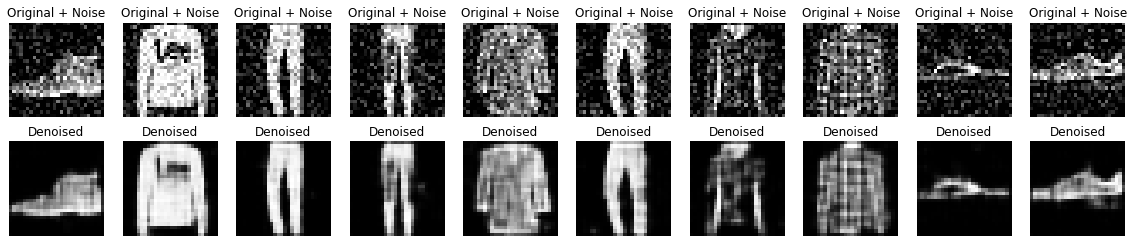

In [27]:
plt.figure(figsize=(20, 4))
for i in range(n):
    plt.subplot(2, n, i+1)
    plt.imshow(tf.squeeze(x_test_noisy[i]))
    plt.title("Original + Noise")
    plt.gray()
    plt.axis('off')

    plt.subplot(2, n, i+1+n)
    plt.imshow(tf.squeeze(denoised_imgs[i]))
    plt.title("Denoised")
    plt.gray()
    plt.axis('off')

plt.show()

#Anomaly detection